<a href="https://colab.research.google.com/github/AceAltair13/facial-expression-recognition/blob/main/RESNET_FER_2013.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'fer2013:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F786787%2F1351797%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240515%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240515T200830Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D626475e97a0022991946af6c4e4a2ef2bbf6949f89b270ade4ed51dfd283c0e9ea189f07f94374979dbc8d108f9e04b240730bec69945ec3e886573760c9136dc71fce96d0a6de1d09a7eb3912c2c3f6825dd29494256c418e229eb6285630ab7ea01659f96555edd01894d572bd6156fdc3087f2fb597624fc3e6649d73d243f0b259da362141652ca69a31afd6f16e9f7b8bb9aa85657ca1e530ff97bd1f37b4a0ab2182b25872cd68ea5816cc37244942cf027fdd92006c75368f25c97d70bb44231bbc8c3fba401c377d06e26ec923142e69666648a1718e9deaa213a5fcb4c1bc0909a9cc6bb6283c3481e7f177221ba87efbd585447c8a66f13fce4ea1'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


# **Introduction**

ResNet50V2 is a modified version of ResNet50 that performs better than ResNet50 and ResNet101 on the ImageNet dataset. In ResNet50V2, a modification was made in the propagation formulation of the connections between blocks. ResNet50V2 also achieves a good result on the ImageNet dataset.

### Importing Necessary Libraries

This section of the code is responsible for importing all the necessary libraries and modules required for the project.

`pandas`: Used for data manipulation and analysis.
`numpy`: Used for numerical operations.
`matplotlib.pyplot`: Used for creating static, animated, and interactive visualizations in Python.
`os`: Provides functions for interacting with the operating system.
`tensorflow`: A free and open-source software library for machine learning and artificial intelligence.
`keras`: A user-friendly neural network library written in Python.
`cv2 (OpenCV)`: Used for image and video processing.
`sklearn.model_selection.train_test_split`: Used to split the data into training set and test set.
Additionally, several modules from tensorflow.keras are imported, which are used for image preprocessing, model callbacks, model visualization, and model layers and optimizers.

Finally, the `ResNet50V2` model from `tensorflow.keras.applications` is imported, which is a variant of the popular ResNet model with some improvements and is used for image classification tasks.



In [ ]:
# Importing necessary libraries

# pandas is used for data manipulation and analysis
import pandas as pd

# numpy is used for numerical operations
import numpy as np

# matplotlib.pyplot is used for creating static, animated, and interactive visualizations in Python
import matplotlib.pyplot as plt

# Setting the style of matplotlib to 'default'
plt.style.use('default')

# os module provides functions for interacting with the operating system
import os

# tensorflow is a free and open-source software library for machine learning and artificial intelligence
import tensorflow as tf

# keras is a user-friendly neural network library written in Python
import keras

# cv2 (OpenCV) is used for image and video processing
import cv2

# sklearn.model_selection.train_test_split is used to split the data into training set and test set
from sklearn.model_selection import train_test_split

# Importing necessary modules from tensorflow.keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers , models, optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *

# Importing ResNet50V2 model from tensorflow.keras.applications
from tensorflow.keras.applications import ResNet50V2

In [ ]:
tf.__version__

'2.6.4'

# **Visualizing Classes**

### Data Preparation

This section of the code is responsible for counting the number of instances in each class in the training and testing datasets.

The `count_classes_in_directory` function takes a directory path and a dataset name as input. It iterates over each class in the directory, counts the number of instances in each class, and stores the counts in a dictionary. The dictionary is then converted to a DataFrame for easier manipulation.

The function is called twice, once for the training data directory and once for the testing data directory. The resulting DataFrames are sorted in descending order by the number of instances in each class.

In [ ]:
# Define the directories for training and testing data
training_data_directory = '../input/fer2013/train/'
testing_data_directory = '../input/fer2013/test/'

# Function to count the number of instances in each class
def count_classes_in_directory(directory_path, dataset_name):
    class_counts = {}

    # Iterate over each class in the directory
    for class_name in os.listdir(directory_path):
        # Construct the full path to the class directory
        full_path = os.path.join(directory_path, class_name)
        # Count the number of instances in the class and store it in the dictionary
        class_counts[class_name] = len(os.listdir(full_path))

    # Convert the dictionary to a DataFrame for easier manipulation
    class_counts_df = pd.DataFrame(class_counts, index=[dataset_name])

    return class_counts_df

# Count the number of instances in each class in the training and testing data
training_class_counts = count_classes_in_directory(training_data_directory, 'Train').transpose().sort_values(by="Train", ascending=False)
testing_class_counts = count_classes_in_directory(testing_data_directory, 'Test').transpose().sort_values(by="Test", ascending=False)

### Combining Training and Testing Class Counts

The `pd.concat` function is used to concatenate the `training_class_counts` and `testing_class_counts` DataFrames along the columns axis (`axis=1`). The result is a new DataFrame, `combined_class_counts`, which contains the counts of each class in both the training and testing datasets.

In [ ]:
# Concatenate the training and testing class counts into a single DataFrame
combined_class_counts = pd.concat([training_class_counts, testing_class_counts], axis=1)

,Train,Test
happy,7215,1774
neutral,4965,1233
sad,4830,1247
fear,4097,1024
angry,3995,958
surprise,3171,831
disgust,436,111


### Plotting Training Class Counts

The `plot` function is used to create a bar plot of the counts of each class in the training data. The 'kind' parameter is set to 'bar' to create a bar plot.

<AxesSubplot:>

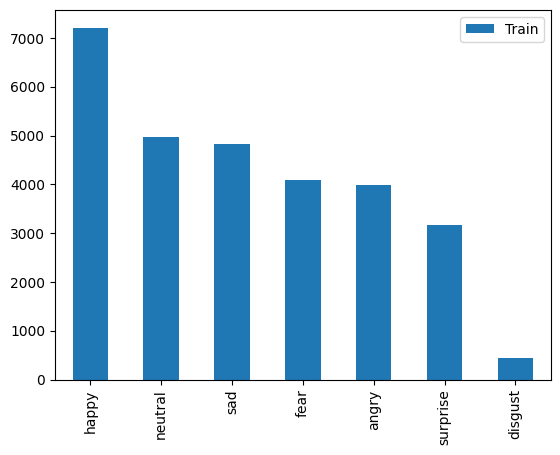

In [ ]:
# Plot the counts of each class in the training data
combined_class_counts['Train'].plot(kind='bar')

### Plotting Testing Class Counts

The `plot` function is used to create a horizontal bar plot of the counts of each class in the testing data. The 'kind' parameter is set to 'barh' to create a horizontal bar plot.

<AxesSubplot:>

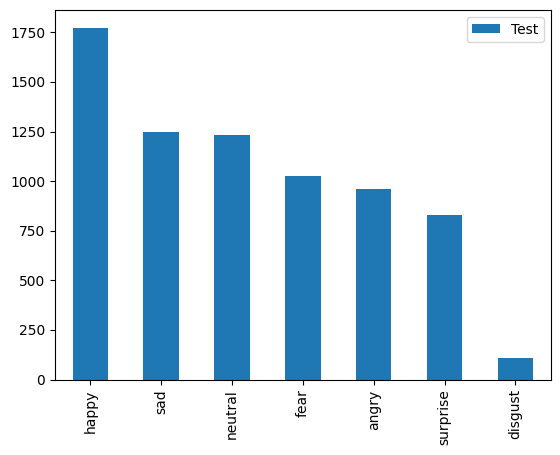

In [ ]:
# Plot the counts of each class in the testing data
combined_class_counts['Test'].plot(kind='bar')

### Setting Up Plotting Parameters & Displaying Images from Each Class

The style of matplotlib is set to 'default', and a new figure is created with a specified size. An `image_count` variable is initialized to keep track of the number of images.

The code iterates over each directory in the base URL, ignoring hidden directories. For each directory, it iterates over the files in the directory and breaks the loop after the first file. It then creates a subplot for the image, increments the `image_count`, reads the image file, displays the image, and sets the title of the subplot to the directory name.

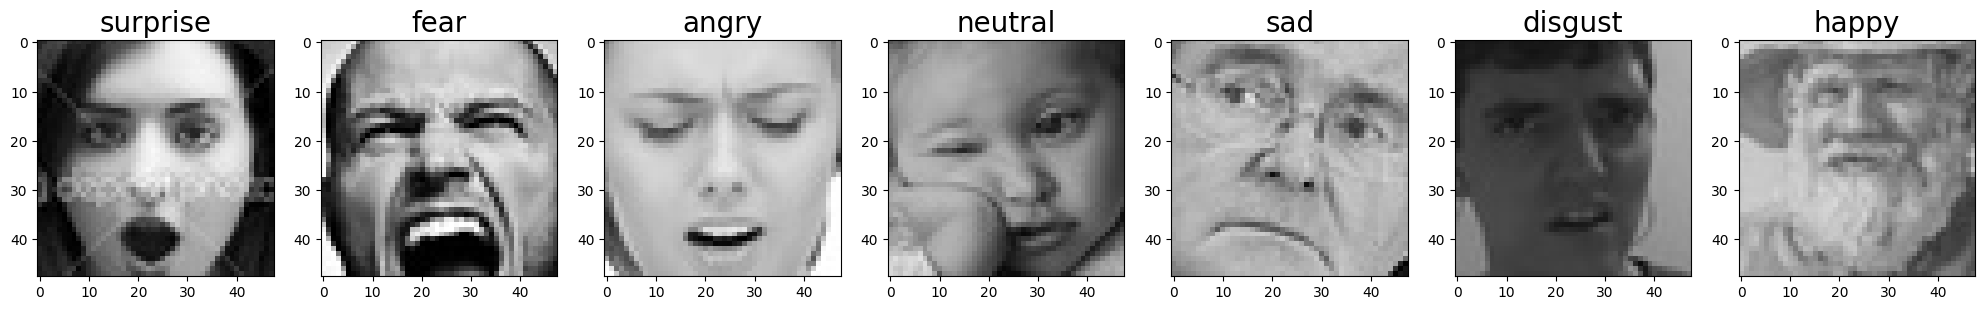

In [ ]:
# Set the style of matplotlib to 'default'
plt.style.use('default')

# Create a new figure with a specified size
plt.figure(figsize=(25, 8))

# Initialize the image count
image_count = 1

# Define the base URL for the training data
training_data_base_url = '../input/fer2013/train/'

# Iterate over each directory in the base URL
for directory in os.listdir(training_data_base_url):
    # Ignore hidden directories
    if directory[0] != '.':
        # Iterate over each file in the directory
        for i, file in enumerate(os.listdir(training_data_base_url + directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(1, 7, image_count)
                image_count += 1
                image = cv2.imread(training_data_base_url + directory + '/' + file)
                plt.imshow(image)
                plt.title(directory, fontsize=20)

# **Data Preprocessing**

### Defining Image Parameters and Data Paths

The shape of the images is defined as 224, meaning that the images will be resized to 224x224 pixels before being fed into the model. The batch size for training is defined as 64, meaning that the model will be trained on batches of 64 images at a time. The paths for the training and testing data are defined, pointing to the directories where the training and testing images are stored.

In [ ]:
# Define the shape of the images
image_shape = 224

# Define the batch size for training
training_batch_size = 64

# Define the paths for the training and testing data
training_data_path = '../input/fer2013/train/'
testing_data_path = '../input/fer2013/test/'

### Data Preprocessing and Generation

The `ImageDataGenerator` class from Keras is used to define preprocessors for the training and testing data. The training data preprocessor includes data augmentation techniques such as random rotation, zooming, shifting, and flipping. The testing data preprocessor only includes rescaling of pixel values.

The `flow_from_directory` method of the `ImageDataGenerator` class is used to generate the training and testing data. The method reads images from the specified directories, applies the preprocessing operations, and returns batches of images along with their labels.

In [ ]:
# Define the preprocessor for the training data
training_data_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
        rotation_range=10,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest',
    )

# Define the preprocessor for the testing data
testing_data_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

# Generate the training data
training_data = training_data_preprocessor.flow_from_directory(
    training_data_path,
    class_mode="categorical",
    target_size=(image_shape, image_shape),
    color_mode='rgb',
    shuffle=True,
    batch_size=training_batch_size,
)

# Generate the testing data
testing_data = testing_data_preprocessor.flow_from_directory(
    testing_data_path,
    class_mode="categorical",
    target_size=(image_shape, image_shape),
    color_mode="rgb",
    shuffle=False,
    batch_size=training_batch_size,
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# **ResNet50V2 Model**

### Defining the ResNet50V2 Model

The `ResNet50V2` model from Keras is defined with an input shape of 224x224x3 (corresponding to the height, width, and number of color channels of the images), without the top layer (the classification layer), and with weights pre-trained on the ImageNet dataset. A summary of the model is then printed.

In [ ]:
# Define the ResNet50V2 model
ResNet50V2 = tf.keras.applications.ResNet50V2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# Print a summary of the model
ResNet50V2.summary()

94683136/94668760 [==============================] - 4s 0us/step
Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
________________________

### Freezing Model Layers

The `ResNet50V2` model is set to be trainable, and then all layers except the last 50 are frozen. This means that the weights of the frozen layers will not be updated during training, while the weights of the last 50 layers will be updated.

In [ ]:
# Set the ResNet50V2 model to be trainable
ResNet50V2.trainable = True

# Freeze all layers except the last 50
for layer in ResNet50V2.layers[:-50]:
    layer.trainable = False

### Defining the ResNet50V2 Model

A function `Create_ResNet50V2_Model` is defined to create a sequential model. The model consists of the base `ResNet50V2` model followed by a dropout layer, a batch normalization layer, a flatten layer, a dense layer, another batch normalization layer, another dropout layer, and finally the output layer.

In [ ]:
def Create_ResNet50V2_Model():
    # Define a sequential model
    model = Sequential([
        ResNet50V2,
        Dropout(.25),
        BatchNormalization(),
        Flatten(),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(.5),
        Dense(7,activation='softmax')
    ])
    return model

### Defining Metrics
The `Precision` and `Recall` metrics from Keras and the `f1_score` metric from scikit-learn are imported. Instances of the `Precision` and `Recall` metrics are then created.

In [ ]:
# Import the Precision and Recall metrics from Keras
from keras.metrics import Precision, Recall

# Import the f1_score metric from scikit-learn
from sklearn.metrics import f1_score

# Define the precision metric
precision = Precision()

# Define the recall metric
recall = Recall()

### Model Creation and Compilation

The `Create_ResNet50V2_Model` function is called to create the `ResNet50V2_Model`. A summary of the model is then printed. The model is compiled with the Adam optimizer, the categorical cross-entropy loss function, and accuracy, precision, and recall as metrics.

In [ ]:
# Create the ResNet50V2 model
ResNet50V2_Model = Create_ResNet50V2_Model()

# Print a summary of the model
ResNet50V2_Model.summary()

# Compile the model with the Adam optimizer, the categorical cross-entropy loss function, and accuracy, precision, and recall as metrics
ResNet50V2_Model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', precision, recall])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 2048)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 2048)        8192      
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                6422592   
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0

### Specifying Callbacks

A `ModelCheckpoint` callback is created to save the model with the best validation accuracy. An `EarlyStopping` callback is created to stop training when the validation accuracy stops improving. A `ReduceLROnPlateau` callback is created to reduce the learning rate when the validation loss stops improving. The number of steps per epoch for training and validation is calculated.

In [ ]:
# Define the path for the model checkpoint
checkpoint_path = "ResNet50V2_Model_Checkpoint"

# Create a ModelCheckpoint callback to save the model with the best validation accuracy
Checkpoint = ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True)

# Create an EarlyStopping callback to stop training when the validation accuracy stops improving
Early_Stopping = EarlyStopping(monitor = 'val_accuracy', patience = 7, restore_best_weights = True, verbose=1)

# Create a ReduceLROnPlateau callback to reduce the learning rate when the validation loss stops improving
Reducing_LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                  factor=0.2,
                                                  patience=2,
                                                  verbose=1)

# Define the list of callbacks
callbacks = [Early_Stopping, Reducing_LR]

# Calculate the number of steps per epoch for training and validation
steps_per_epoch = train_data.n // train_data.batch_size
validation_steps = test_data.n // test_data.batch_size

### Model Training

The `fit` method of the `ResNet50V2_Model` is called to train the model on the training data, using the testing data for validation, for 60 epochs, with the specified batch size and callbacks, and the calculated number of steps per epoch and validation steps. The history of the training is saved in `ResNet50V2_history`.

In [ ]:
# Train the model on the training data, using the testing data for validation, for 60 epochs, with the specified batch size and callbacks, and the calculated number of steps per epoch and validation steps
ResNet50V2_history = ResNet50V2_Model.fit(train_data, validation_data=test_data, epochs=60, batch_size=batch_size,
                                          callbacks=callbacks, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)

Epoch 1/60
448/448 [==============================] - 553s 1s/step - loss: 1.4909 - accuracy: 0.4783 - precision: 0.6691 - recall: 0.2833 - val_loss: 1.1876 - val_accuracy: 0.5569 - val_precision: 0.7179 - val_recall: 0.3838
Epoch 2/60
448/448 [==============================] - 380s 848ms/step - loss: 1.2316 - accuracy: 0.5557 - precision: 0.7239 - recall: 0.3667 - val_loss: 1.0843 - val_accuracy: 0.6010 - val_precision: 0.7241 - val_recall: 0.4501
Epoch 3/60
448/448 [==============================] - 371s 828ms/step - loss: 1.1147 - accuracy: 0.5940 - precision: 0.7383 - recall: 0.4250 - val_loss: 1.0847 - val_accuracy: 0.6155 - val_precision: 0.7250 - val_recall: 0.4840
Epoch 4/60
448/448 [==============================] - 375s 837ms/step - loss: 1.0878 - accuracy: 0.6086 - precision: 0.7556 - recall: 0.4355 - val_loss: 1.0607 - val_accuracy: 0.6069 - val_precision: 0.7303 - val_recall: 0.4683
Epoch 5/60
448/448 [==============================] - 366s 817ms/step - loss: 1.0278 - accu

# **Evaluating ResNet50V2**

### Model Evaluation

The `evaluate` method of the `ResNet50V2_Model` is called to evaluate the model on the testing data. The test loss and test accuracy are then printed.

In [ ]:
# Evaluate the model on the testing data
ResNet50V2_Score = ResNet50V2_Model.evaluate(test_data)

# Print the test loss and test accuracy
print("Test Loss:     {:.5f}".format(ResNet50V2_Score[0]))
print("Test Accuracy: {:.2f}%".format(ResNet50V2_Score[1] * 100))

113/113 [==============================] - 21s 182ms/step - loss: 0.9315 - accuracy: 0.6910 - precision: 0.7410 - recall: 0.6436
Test Loss:     0.93153
Test Accuracy: 69.10%


### Plotting Training History

A function `plot_curves` is defined to plot the training and validation loss, accuracy, precision, and recall over the epochs. The function is then called with the training history `ResNet50V2_history`.

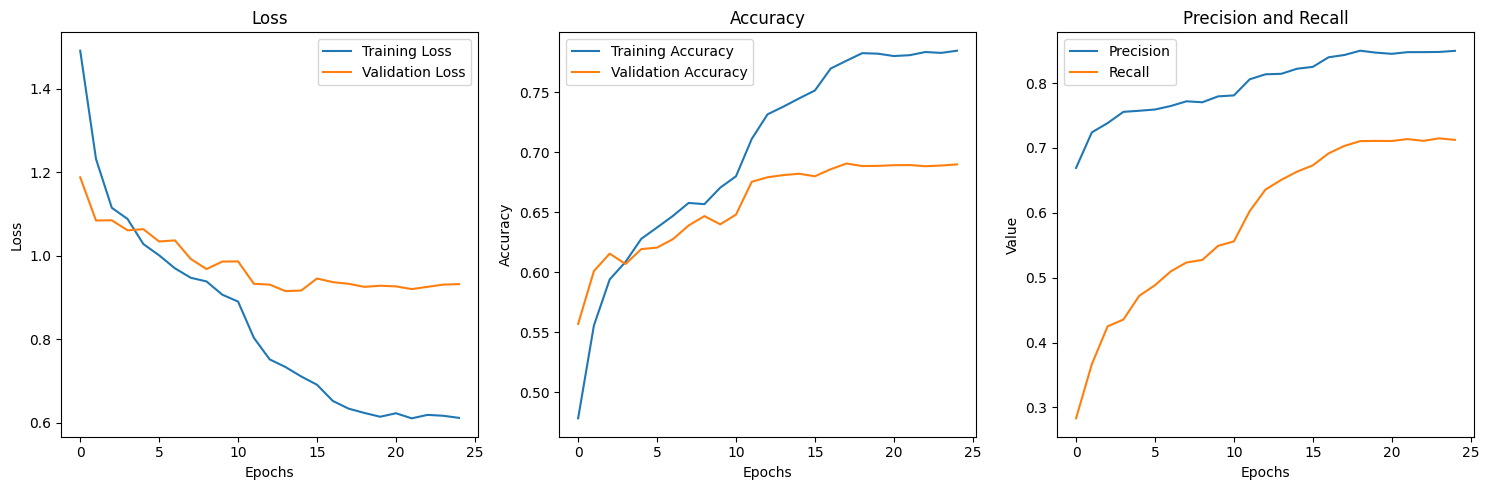

In [ ]:
def plot_curves(history):
    # Extract the loss, accuracy, precision, and recall from the history
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    precision = history.history["precision"]
    recall = history.history["recall"]

    # Create a list of epochs
    epochs = range(len(history.history["loss"]))

    # Create a new figure
    plt.figure(figsize=(15,5))

    # Plot the training and validation loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, loss, label="Training Loss")
    plt.plot(epochs, val_loss, label="Validation Loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Plot the training and validation accuracy
    plt.subplot(1, 3, 2)
    plt.plot(epochs, accuracy, label="Training Accuracy")
    plt.plot(epochs, val_accuracy, label="Validation Accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    # Plot the precision and recall
    plt.subplot(1, 3, 3)
    plt.plot(epochs, precision, label="Precision")
    plt.plot(epochs, recall, label="Recall")
    plt.title("Precision and Recall")
    plt.xlabel("Epochs")
    plt.ylabel("Value")
    plt.legend()

    # Adjust the layout and display the plots
    plt.tight_layout()
    plt.show()

# Call the plot_curves function with the training history
plot_curves(ResNet50V2_history)

### Making Predictions

The `predict` method of the `ResNet50V2_Model` is called to make predictions on the testing data. For each prediction, the class with the highest probability is chosen.

In [ ]:
# Use the model to make predictions on the testing data
ResNet50V2_Predictions = ResNet50V2_Model.predict(test_data)

# For each prediction, choose the class with the highest probability
ResNet50V2_Predictions = np.argmax(ResNet50V2_Predictions, axis=1)

### Final Metrics

The final accuracy, precision, recall, and validation loss are extracted from the training history. The final F1 score is then calculated. The final metrics are printed.

In [ ]:
# Extract the final accuracy, precision, recall, and validation loss from the training history
final_accuracy = ResNet50V2_history.history['accuracy'][-1]
final_precision = ResNet50V2_history.history['precision'][-1]
final_recall = ResNet50V2_history.history['recall'][-1]
final_val_loss = ResNet50V2_history.history['val_loss'][-1]

# Calculate the final F1 score
final_f1_score = (2 * final_precision * final_recall) / (final_precision + final_recall)

# Print the final metrics
print("*" * 8, "Final Metrics", "*" * 8)
print("Final Accuracy        : {:.2%}".format(final_accuracy))
print("Final Precision       : {:.2%}".format(final_precision))
print("Final Recall          : {:.2%}".format(final_recall))
print("Final Validation Loss : {:.4f}".format(final_val_loss))
print("Final F1 Score        : {:.3}".format(final_f1_score))

******** Final Metrics ********
Final Accuracy        : 78.46%
Final Precision       : 84.95%
Final Recall          : 71.23%
Final Validation Loss : 0.9319
Final F1 Score        : 0.775


### Confusion Matrix

Seaborn and `confusion_matrix` from sklearn.metrics are imported. A confusion matrix is computed between the true labels and the predicted labels. A heatmap of the confusion matrix is then created and labeled.

Text(0.5, 1.0, 'ResNet50V2 Confusion Matrix')

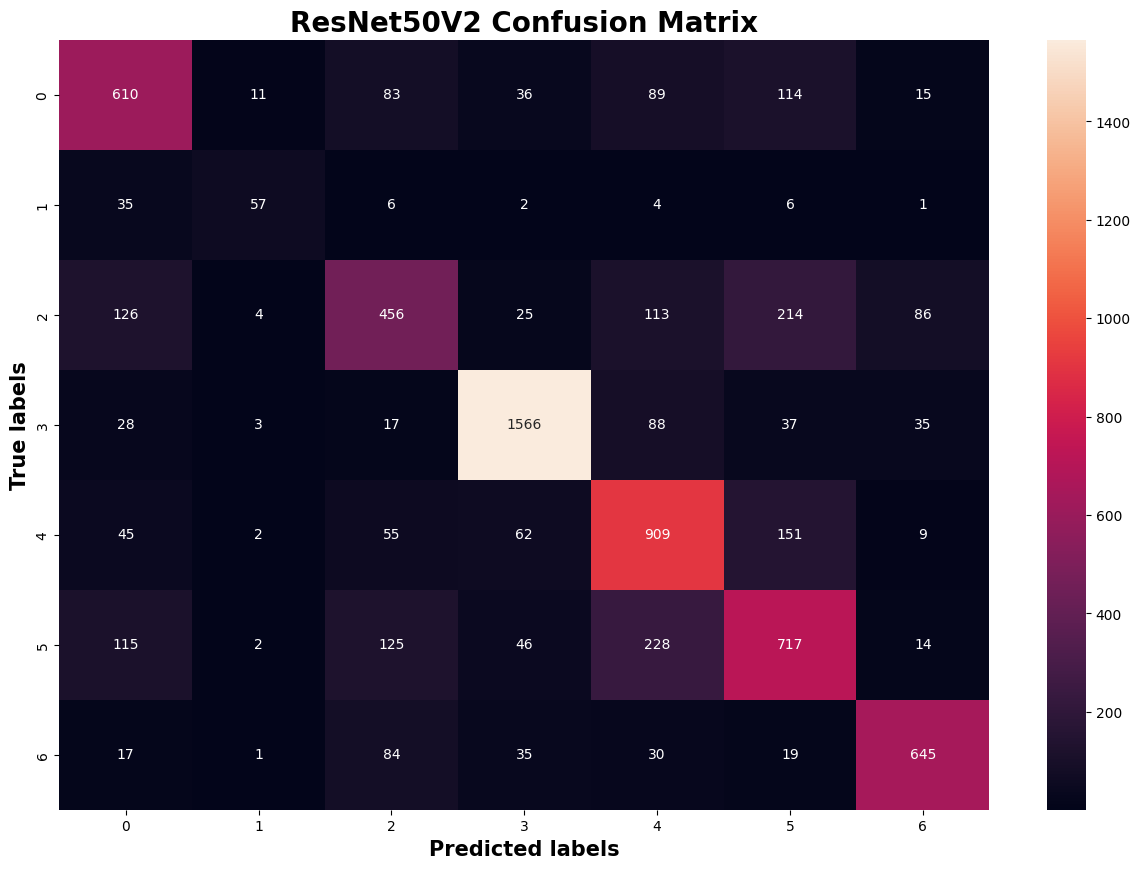

In [ ]:
# Import seaborn for data visualization
import seaborn as sns
# Import confusion_matrix from sklearn.metrics
from sklearn.metrics import confusion_matrix

# Create a new figure with specified size
fig, ax= plt.subplots(figsize=(15,10))

# Compute the confusion matrix between the true labels and the predicted labels
cm=confusion_matrix(test_data.labels, ResNet50V2_Predictions)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, fmt='g', ax=ax)

# Set the labels and title of the heatmap
ax.set_xlabel('Predicted labels', fontsize=15, fontweight='bold')
ax.set_ylabel('True labels', fontsize=15, fontweight='bold')
ax.set_title('ResNet50V2 Confusion Matrix', fontsize=20, fontweight='bold')

# **Visualizing Predictions**

### Class Names
The class indices are extracted from the testing data. A list of the class names, capitalized, is created and printed.

In [ ]:
# Extract the class indices from the testing data
class_indices = test_data.class_indices

# Create a list of the class names, capitalized
Emotion_Classes = [key.capitalize() for key in class_indices.keys()]

# Print the list of class names
print(Emotion_Classes)

['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']


### Test Data Preprocessing
An `ImageDataGenerator` is created for preprocessing the test data. The images are rescaled to have values between 0 and 1. The `ImageDataGenerator` is used to load the test data from the directory. The images are loaded in the specified target size and color mode, and are shuffled. The class mode is set to "categorical" for multi-class classification.

In [ ]:
# Create an ImageDataGenerator for preprocessing the test data
test_preprocessor = ImageDataGenerator(rescale = 1 / 255.)

# Use the ImageDataGenerator to load the test data from the directory
test_generator = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=True,
    batch_size=batch_size,
)

Found 7178 images belonging to 7 classes.


# **ResNet50V2 Predictions**

### Image Predictions
A random batch is selected from the test generator, and 10 random images are selected from the batch. Each image is resized, and a prediction is made using the model. The images are displayed in a 2x5 grid, with the true and predicted labels as the title. If the prediction is correct, the title color is green, otherwise it's red.

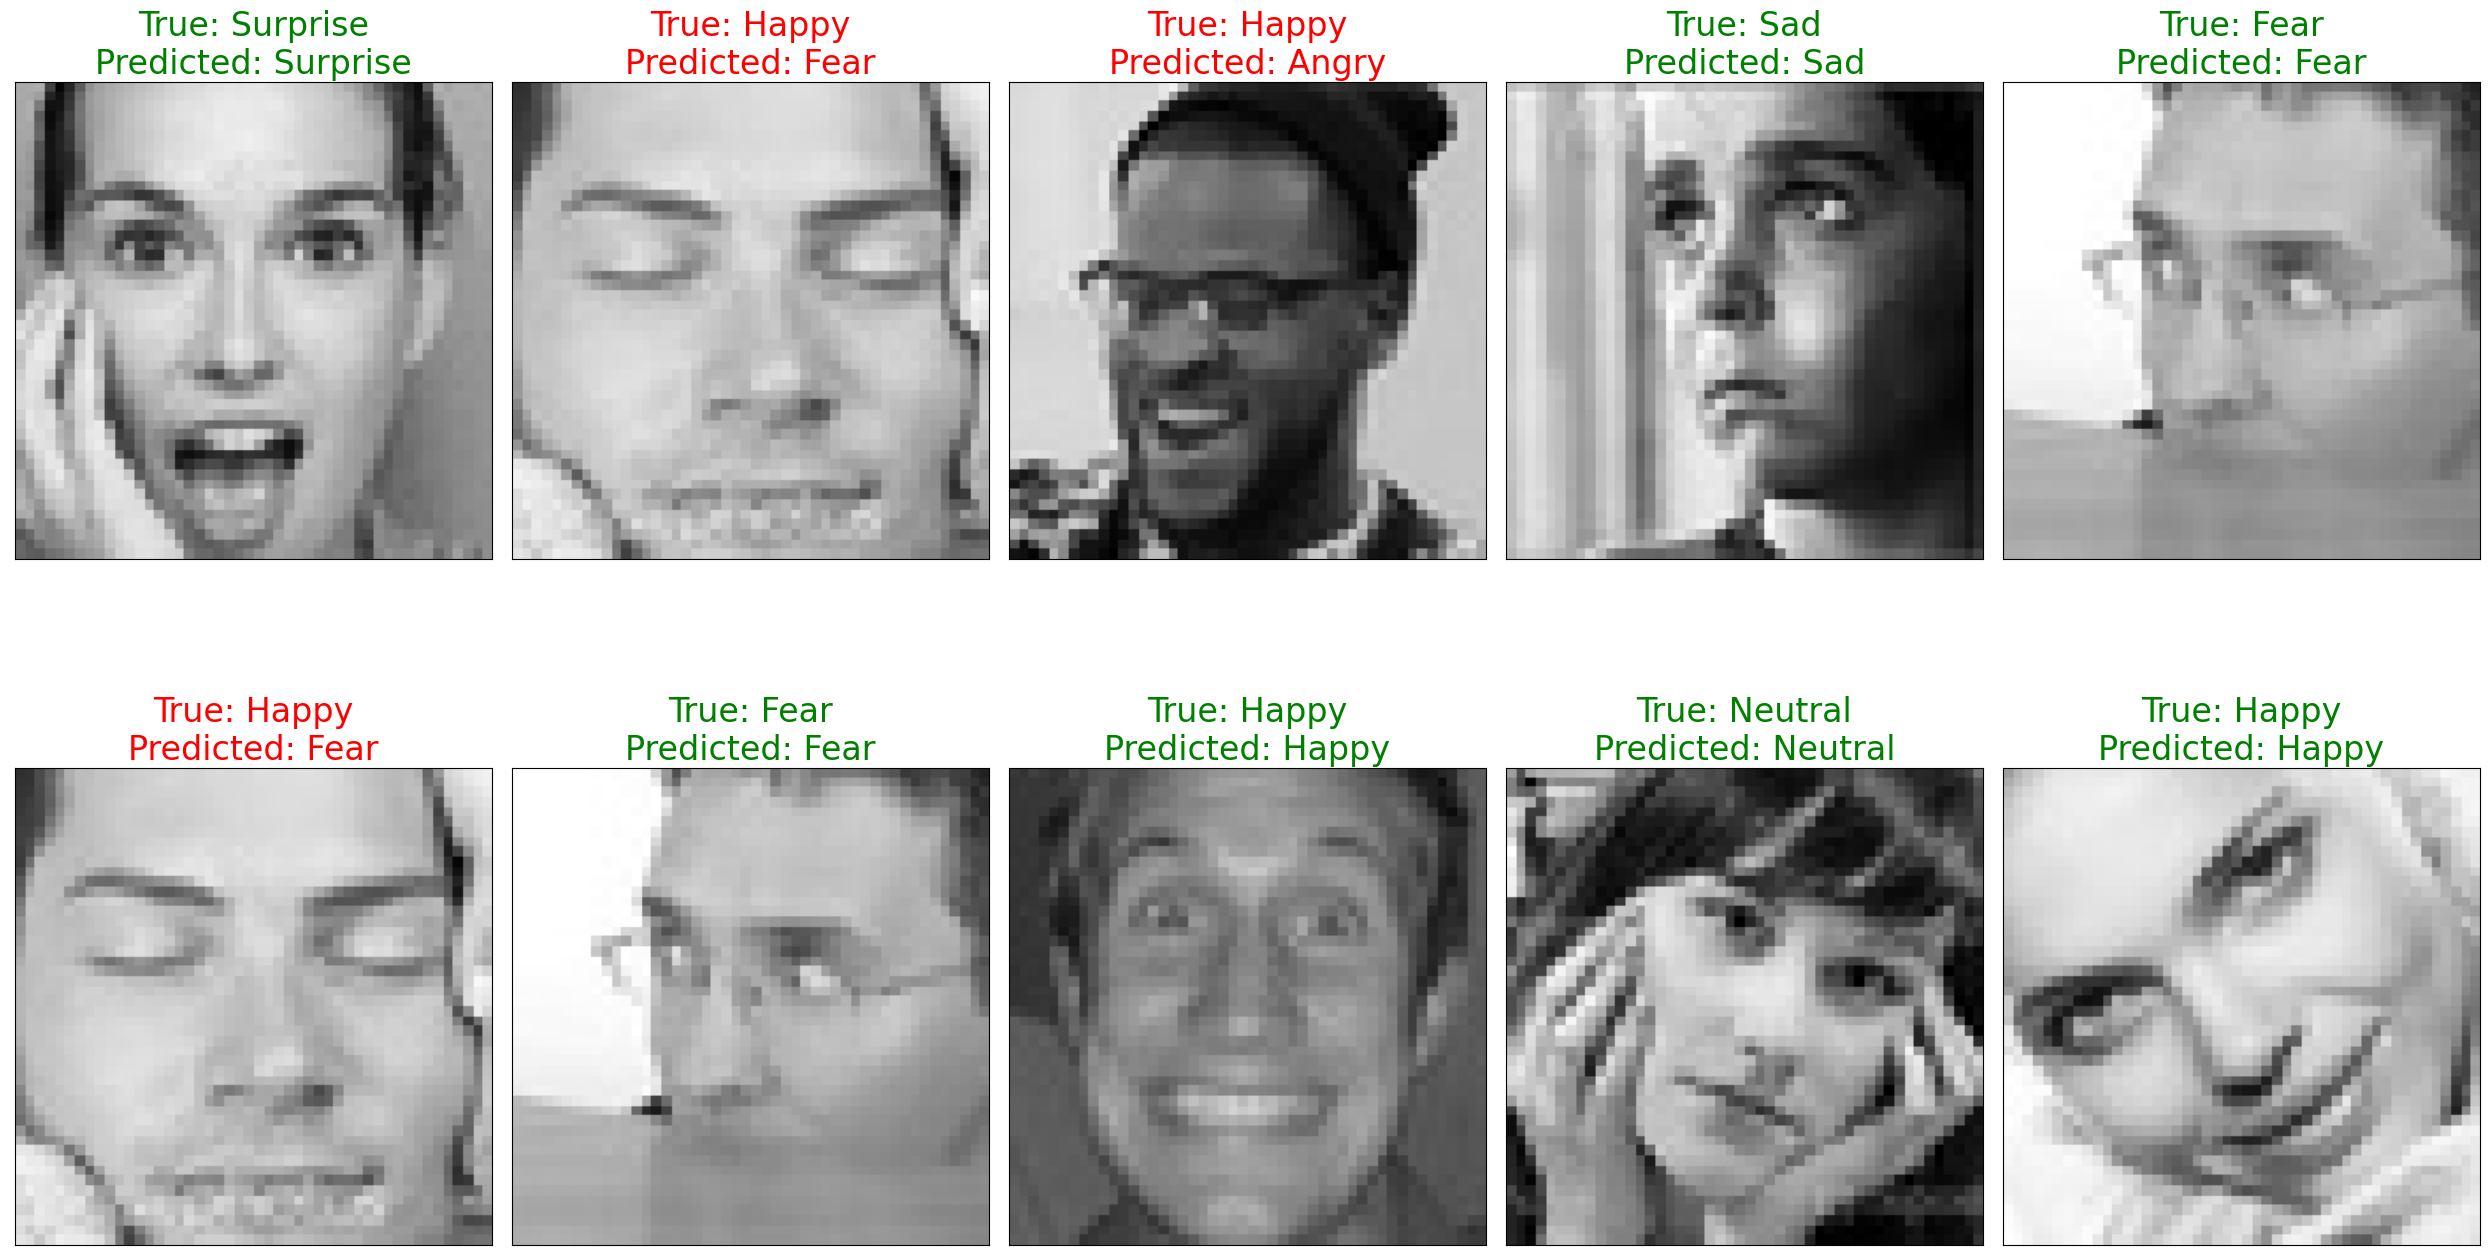

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize

# Select a random batch from the test generator
Random_batch = np.random.randint(0, len(test_generator) - 1)

# Select 10 random images from the batch
Random_Img_Index = np.random.randint(0, batch_size - 1, 10)

# Create a new figure with 2 rows and 5 columns
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 15),
                         subplot_kw={'xticks': [], 'yticks': []})

# For each of the 10 images
for i, ax in enumerate(axes.flat):
    # Extract the image and resize it
    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]
    Random_Img_resized = resize(Random_Img, (224, 224), anti_aliasing=True)

    # Extract the true label and make a prediction using the model
    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]])
    Model_Prediction = np.argmax(ResNet50V2_Model.predict(Random_Img_resized.reshape(1, 224, 224, 3), verbose=0))

    # Display the image
    ax.imshow(Random_Img_resized)

    # If the prediction is correct, set the title color to green, otherwise set it to red
    if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction]:
        color = "green"
    else:
        color = "red"

    # Set the title to the true and predicted labels
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color, fontsize=24)

# Adjust the layout and display the plots
plt.tight_layout()
plt.show()